# CS-E4600 — Programming project

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy.sparse import csgraph

## Read file

In [4]:
file = 'CA-GrQc.txt'

## Read Edges

In [5]:
pd_edges = pd.read_csv('./graphs_processed/' + file, sep=" ", skiprows=range(0, 1), header=None)
pd_edges.columns = ["FromNodeId","ToNodeId"]
#pd_edges

## Select Distinct Nodes

In [6]:
node_candidates_1 = pd_edges.drop_duplicates(subset="FromNodeId")["FromNodeId"]
node_candidates_2 = pd_edges.drop_duplicates(subset="ToNodeId")["ToNodeId"]

In [7]:
pd_nodes = pd.concat([node_candidates_1, node_candidates_2])
pd_nodes = pd_nodes.drop_duplicates()
#pd_nodes

## Convert Nodes to Numpy

In [8]:
nodes = pd_nodes.values
edges = pd_edges.values
#nodes.shape, edges.shape

## Create Adjacency Matrix

In [9]:
adjacency_matrix = np.zeros((nodes.size, nodes.size))
#adjacency_matrix.shape

In [10]:
for i in range(0,edges.shape[0]):
    adjacency_matrix[edges[i,0], edges[i,1]] = 1
    adjacency_matrix[edges[i,1], edges[i,0]] = 1
#np.sum(adjacency_matrix)
#plt.imshow(adjacency_matrix)

## Create Laplacian Matrix

In [11]:
laplacian = csgraph.laplacian(adjacency_matrix, normed=True)
np.sum(laplacian)

656.1491255509026

In [12]:
L = np.identity((nodes.size))


## Calculate Eigenvectors

In [13]:
w, v = np.linalg.eig(laplacian)

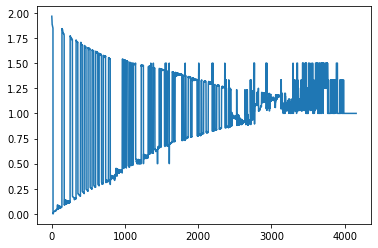

In [15]:
plt.plot(w)